In [1]:
import sys
import os

In [2]:
from importer import *
from utils import *

In [3]:
CLIPS_ROOT = raw_clip_data
SAVE_ROOT = os.path.join(save_clip_data, 'mask_pose')
SAVE_ROOT

'/media/haruyaishikawa/new_disk/save_clip_data/mask_pose'

### Check events

In [4]:
events = [event_names[i] for i in event_ids]
events

['meal time',
 'meeting',
 'coffee break',
 'nap',
 'cooking',
 'working',
 'tending to plants']

### Activate clip management

Testing for 'coffee break':

In [5]:
event = events[4]
clip_id = 2

#### Show images

In [6]:
dm = ShortClipManagement(event, CLIPS_ROOT, SAVE_ROOT)
clips = dm.change_event(event)

clip = clips[clip_id]
rgb_images = dm.get_sorted_rgb_images(clip)

Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [7]:
# %matplotlib widget
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

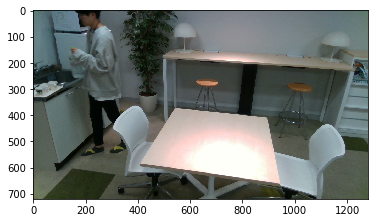

In [8]:
image_num = 201

image_path = os.path.join(dm.get_rgb_path(clip), rgb_images[image_num])

image = mpimg.imread(image_path)
plt.imshow(image)

In [9]:
manager = ClipsSavedDataManagement(event=event, root_path=SAVE_ROOT)

Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [10]:
clips = manager.change_event(event)

Using Event cooking
Available clips
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


In [11]:
clip = clips[clip_id]  # choose first clip

### Analysis

In [12]:
all_files = manager.get_sorted_npz_files(clip)
# files
print(len(all_files))

762


In [13]:
# starting point of clip
init = 200

length = len(all_files)
splits = 10
seg = int(length//splits)
print('segemnts: ', seg)

files = all_files[init:init+seg]

segemnts:  76


### Pose

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage.filters import gaussian_filter

In [15]:
eventmap_pose_dict

{'hands': [7, 4],
 'legs': [13, 12, 10, 9],
 'body': [5, 11, 2, 8],
 'head': [15, 14, 0]}

In [16]:
# in milimeters
y_min = -2500
y_max = 1500
x_min = -2500
x_max = 1500
bin_x = 100  # 10cm
bin_y = 100

sigma = 0.7

xedges = [i for i in range(x_min, x_max, bin_x)]
yedges = [i for i in range(y_min, y_max, bin_y)]


def single_histogram(points, xedges, yedges):
    '''
    Return histogram from points
    '''
    # get all grid points
    x = points[0][~np.isnan(points[0])]
    y = points[1][~np.isnan(points[1])]
    # z = points[2][~np.isnan(points[1])]
    
    # create histogram2d
    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    H = H.T
    
#     print(type(xedges))
#     print(xedges)
    
    # gaussian filter
    H = gaussian_filter(H, sigma=sigma)
    
    # normalize
    if H.max() != 0:
        H = H/H.max()
        
    return H

In [17]:
def process_body_part(pose, joints):
    '''
    Process single body part given joints
    joints = [array of joint values]
    '''
    # initialize
    points = np.empty((len(joints), 3))
    points[:] = np.nan
    
    for i, joint in enumerate(joints):
        point = pose[joint]
        
        if (point == [0,0,0]).all():
            continue
        
        points[i] = pose[joint]
        
    # change axis
    points = np.rollaxis(points, 1)
        
    H = single_histogram(points, xedges, yedges)
    
    return H
    

#### Process a single file

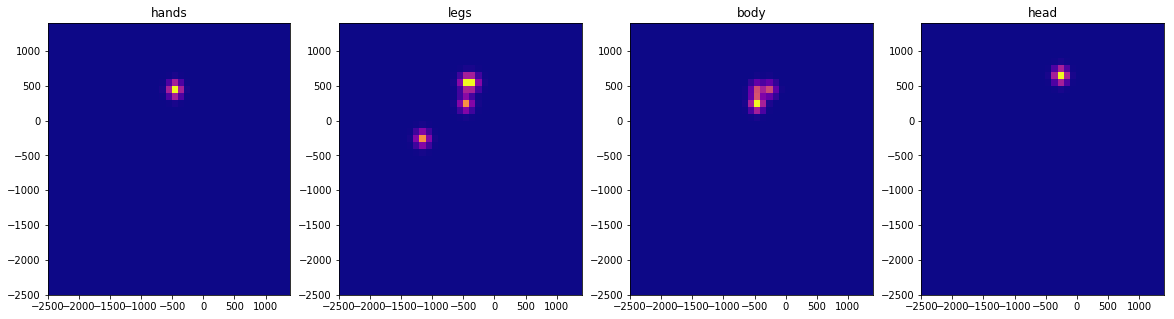

In [18]:
file = files[0]

# get poses
filename = os.path.join(manager.get_clip_directory(clip), file)
poses, _ = poses_masks_from_npz(filename)

# Figure for visualization
fig, axs = plt.subplots(1, len(eventmap_pose_dict), 
                        figsize=(20, 5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(xedges, yedges)

single_pose_averages = {}

# initialize pose averages
for name, value in eventmap_pose_dict.items():
    points = np.empty((3, 1))
    points[:] = np.nan
    
    H = single_histogram(points, xedges, yedges)
    
    single_pose_averages[name] = H

# multiple people
if not(poses is None):
    for i, pose in poses.items():
        # for each people
        for name, joints in eventmap_pose_dict.items():

            H = process_body_part(pose, joints)

            single_pose_averages[name] += H


# plot
for name, H in single_pose_averages.items():
    if H.max() != 0:
        H = H/H.max()
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 


# save fig
fig.savefig('pose_plots.png', dpi=fig.dpi)

#### Process all files

In [19]:
pose_averages = {}

# initialize pose averages
for name, value in eventmap_pose_dict.items():
    points = np.empty((3, 1))
    points[:] = np.nan
    
    H = single_histogram(points, xedges, yedges)
    
    pose_averages[name] = H
    

count = 0
    
# iterate through all files
for i, f in enumerate(files):
    filename = os.path.join(manager.get_clip_directory(clip), f)
    poses, _ = poses_masks_from_npz(filename)
    
    if poses is None:
        continue
    
    # multiple people
    for i, pose in poses.items():
        # for each people
        for name, joints in eventmap_pose_dict.items():

            H = process_body_part(pose, joints)
            
            # accumulate histograms
            pose_averages[name] += H
            
            count += 1

print(f'# of poses: {count}')

# of poses: 304


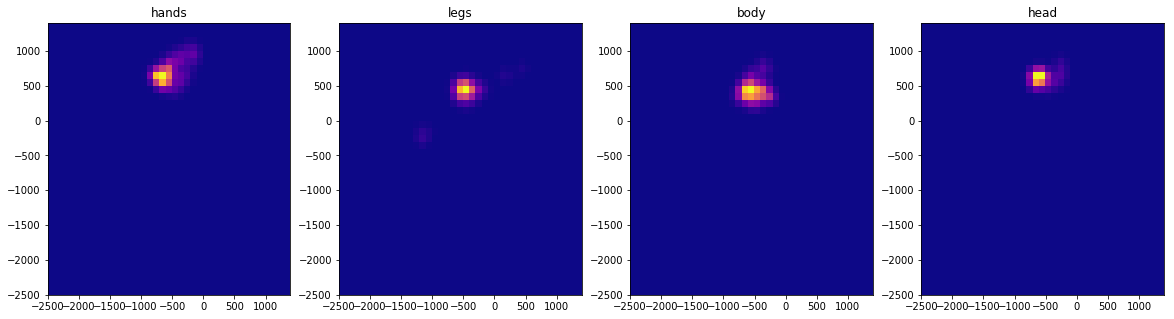

In [20]:
# Figure for visualization
fig, axs = plt.subplots(1, len(eventmap_pose_dict), 
                        figsize=(20, 5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(xedges, yedges)

for name, H in pose_averages.items():
    # normalize
    if H.max() != 0:
        H = H/H.max()
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 

fig.savefig('pose_plots_all.png', dpi=fig.dpi)

### Object

In [21]:
eventmap_object_dict

{'person': [1],
 'bottle': [44],
 'cup': [46, 47],
 'utensil': [48, 49, 50],
 'bowl': [51],
 'chair': [62],
 'potted plant': [64],
 'dining table': [67],
 'laptop': [73],
 'cell phone': [77],
 'microwave': [78],
 'sink': [81],
 'refridgerator': [82],
 'book': [84]}

In [22]:
def process_object(points):
    points = np.rollaxis(points, 1)
    H = single_histogram(points, xedges, yedges)
    return H

#### Process a single file

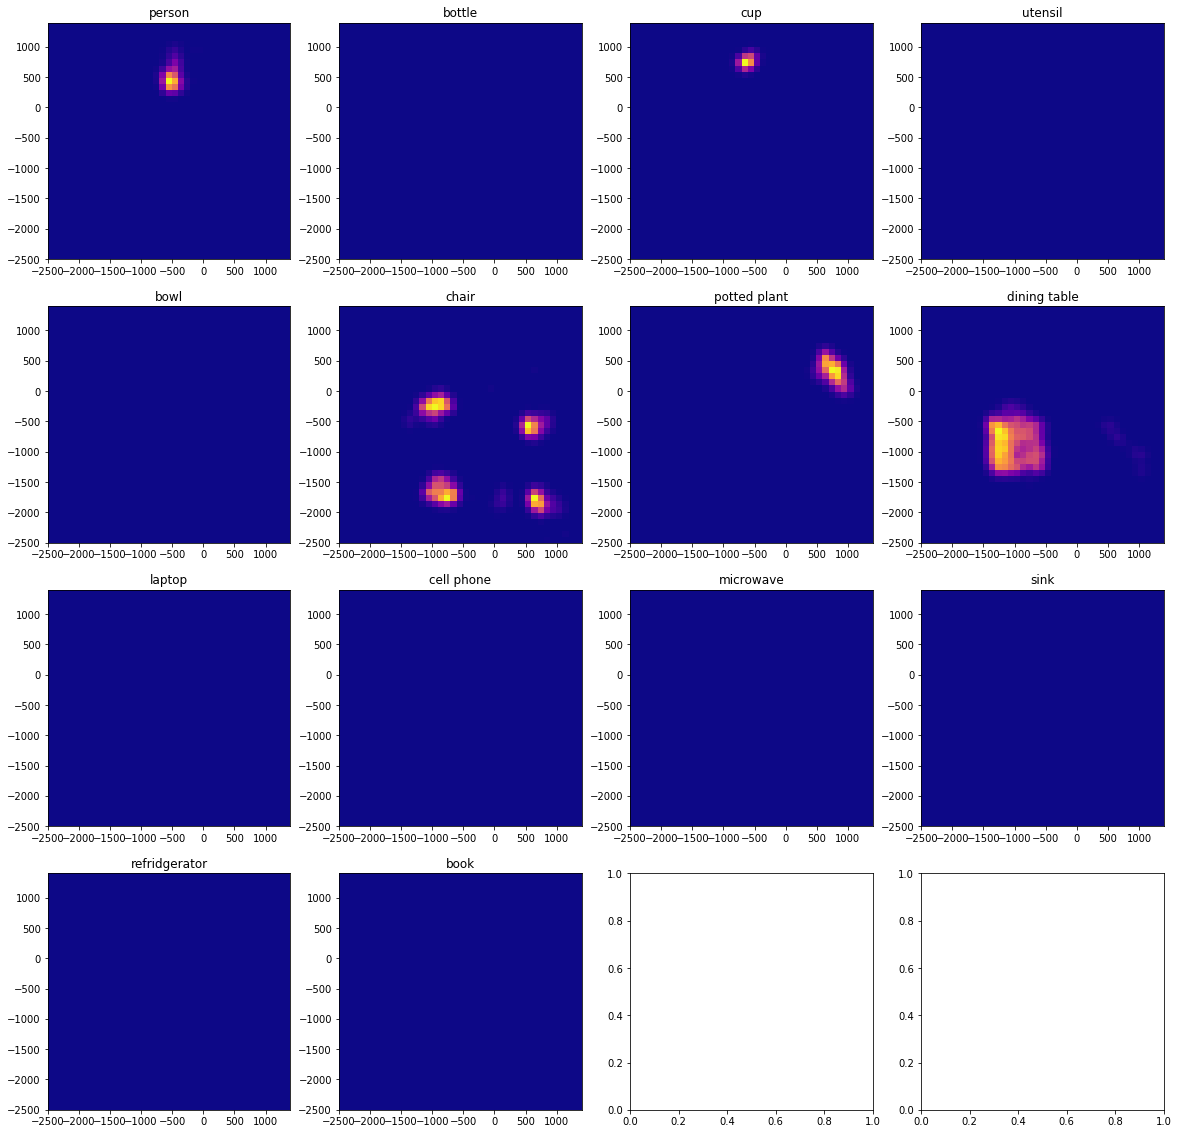

In [23]:
file = files[11]

# get masks
filename = os.path.join(manager.get_clip_directory(clip), file)
_, masks = poses_masks_from_npz(filename)

# Figure for visualization
rows = 3
fig, axs = plt.subplots(rows+1, len(eventmap_object_dict)//rows, 
                        figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(xedges, yedges)

single_object_averages = {}

# initialize pose averages
for name, value in eventmap_object_dict.items():
    points = np.empty((3, 1))
    points[:] = np.nan
    
    H = single_histogram(points, xedges, yedges)
    
    single_object_averages[name] = H


# get data
for mask in masks:
    
    object_id = int(mask.split('_')[0])
    
    for object_name, object_ids in eventmap_object_dict.items():
        if object_id in object_ids:
            mask = masks[mask]

            H = process_object(mask)
                
            single_object_averages[object_name] += H


# plot
for name, H in single_object_averages.items():
    if H.max() != 0:
        H = H/H.max()
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 
    
# save fig
fig.savefig('object_plots.png', dpi=fig.dpi)

plot all points

In [24]:
object_averages = {}

# initialize pose averages
for name, value in eventmap_object_dict.items():
    points = np.empty((3, 1))
    points[:] = np.nan
    
    H = single_histogram(points, xedges, yedges)
    
    object_averages[name] = H
    

count = 0
    
# iterate through all files
for i, f in enumerate(files):
    filename = os.path.join(manager.get_clip_directory(clip), f)
    _, masks = poses_masks_from_npz(filename)
    
    if masks is None:
        continue
    
    for mask in masks:
    
        object_id = int(mask.split('_')[0])

        for object_name, object_ids in eventmap_object_dict.items():
            if object_id in object_ids:
                mask = masks[mask]

                H = process_object(mask)

                object_averages[object_name] += H
            
        count += 1

print(f'# of masks: {count}')

# of masks: 583


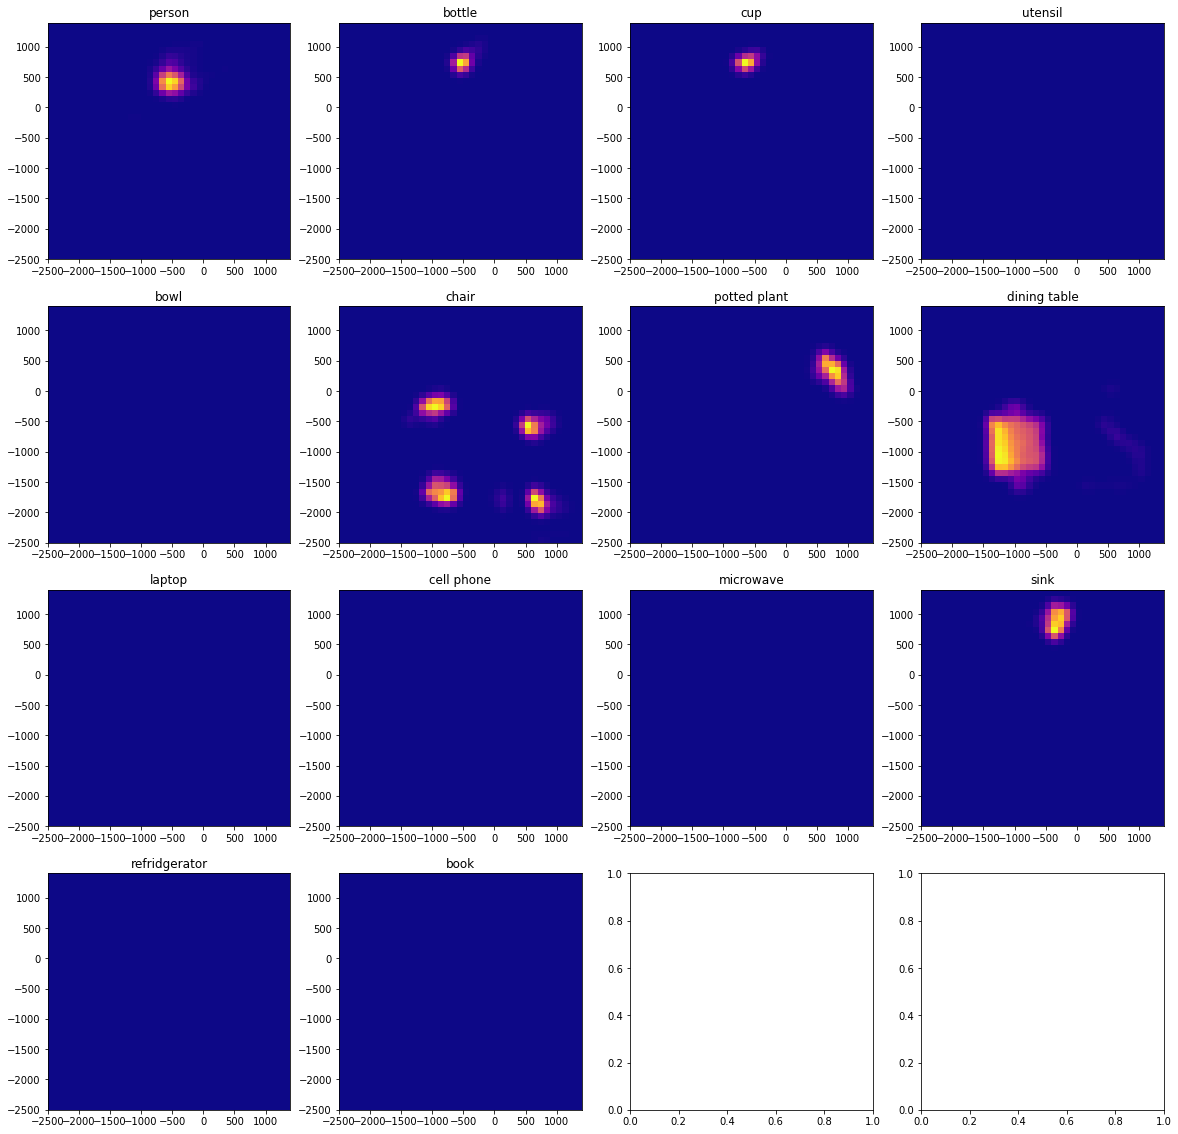

In [25]:
# Figure for visualization
rows = 3
fig, axs = plt.subplots(rows+1, len(eventmap_object_dict)//rows, 
                        figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(xedges, yedges)

for name, H in object_averages.items():
    # normalize
    if H.max() != 0:
        H = H/H.max()
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 

fig.savefig('object_plots_all.png', dpi=fig.dpi)

### Control everything:

single image

In [26]:
def process_poses(poses, pose_averages, pose_dict=eventmap_pose_dict):
    # multiple people
    for i, pose in poses.items():
        # for each people
        for name, joints in pose_dict.items():

            H = process_body_part(pose, joints)

            pose_averages[name] += H
            
    return pose_averages


def process_masks(masks, object_averages, object_dict=eventmap_object_dict):
    for mask in masks:
    
        object_id = int(mask.split('_')[0])

        for object_name, object_ids in eventmap_object_dict.items():
            if object_id in object_ids:
                mask = masks[mask]

                H = process_object(mask)
                
                object_averages[object_name] += H
                
    return object_averages


In [27]:
pose_averages = {}
object_averages = {}

# initialize averages
points = np.empty((3, 1))
points[:] = np.nan
H = single_histogram(points, xedges, yedges)

for name, value in eventmap_pose_dict.items():
    pose_averages[name] = H.copy()

for name, value in eventmap_object_dict.items():
    object_averages[name] = H.copy()
    

# get single file
file = files[0]

# get poses and masks
filename = os.path.join(manager.get_clip_directory(clip), file)
poses, masks = poses_masks_from_npz(filename)

pose_averages = process_poses(poses, pose_averages)
object_averages = process_masks(masks, object_averages)

##### Visualize

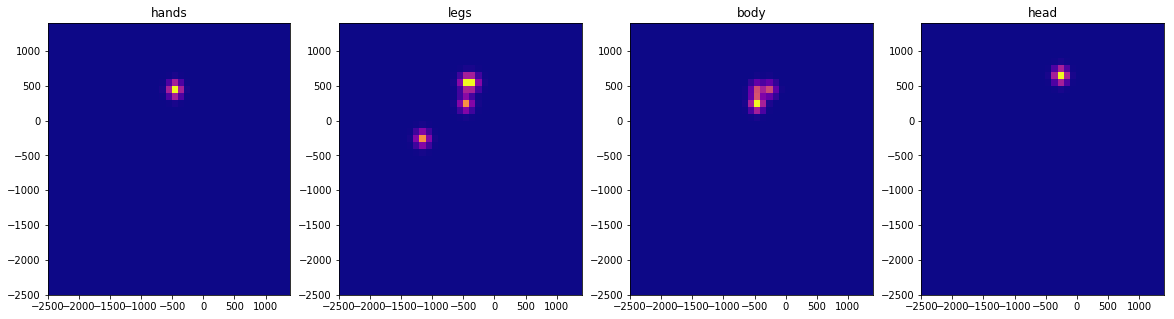

In [28]:
# poses:

# Figure for visualization
fig, axs = plt.subplots(1, len(eventmap_pose_dict), 
                        figsize=(20, 5), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(xedges, yedges)

for name, H in single_pose_averages.items():
    if H.max() != 0:
        H = H/H.max()
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 
    

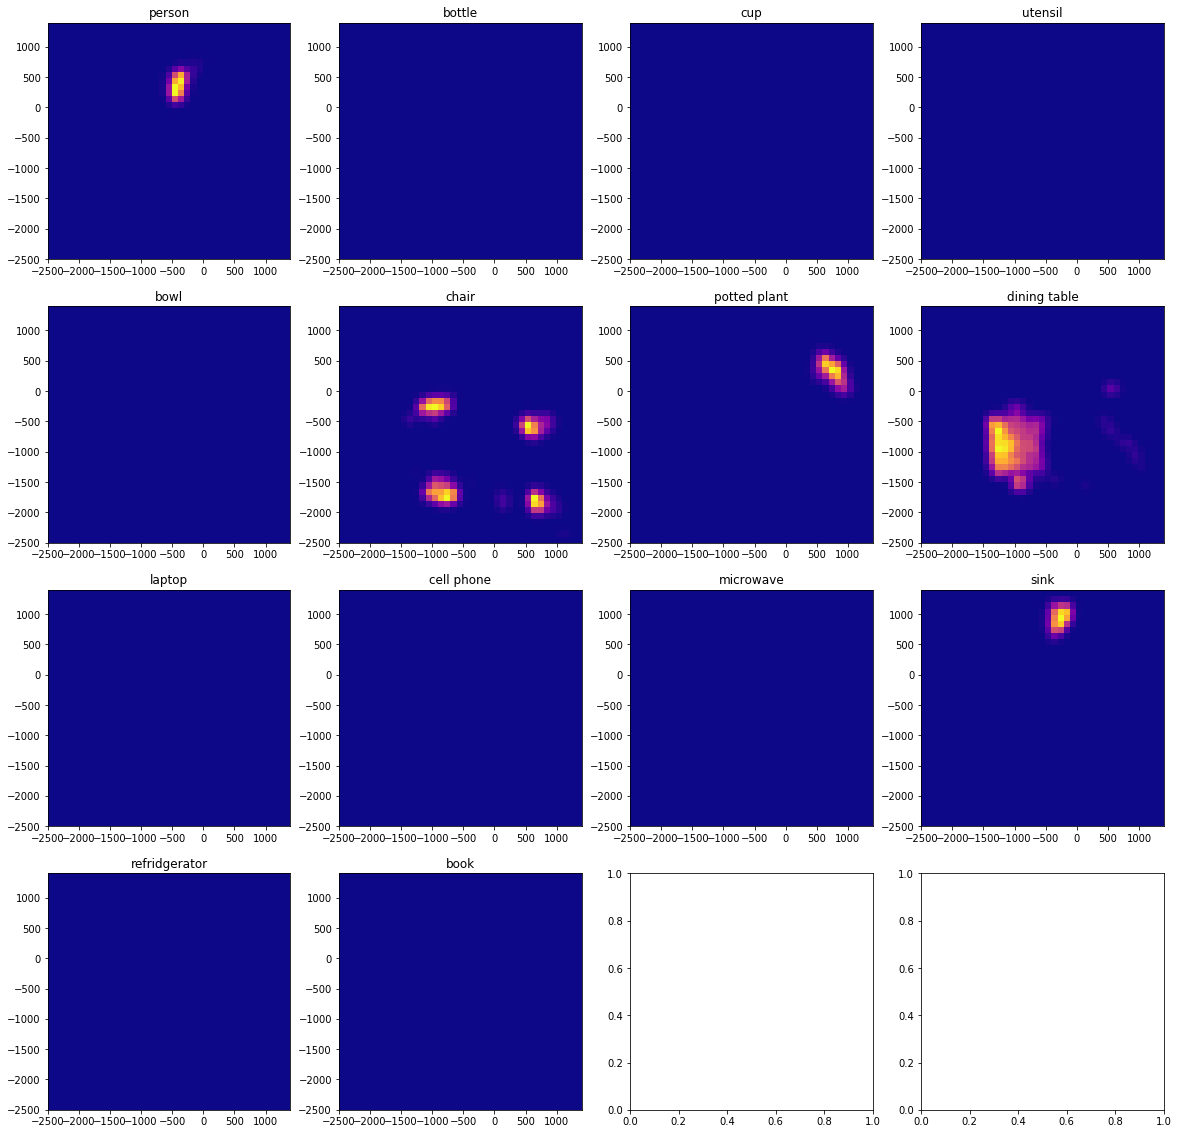

In [29]:
# objects:

# Figure for visualization
rows = 3
fig, axs = plt.subplots(rows+1, len(eventmap_object_dict)//rows, 
                        figsize=(20, 20), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
axs_index = 0

colormap = 'plasma'
X, Y = np.meshgrid(xedges, yedges)

for name, H in object_averages.items():
    # normalize
    if H.max() != 0:
        H = H/H.max()
    axs[axs_index].pcolormesh(X, Y, H, cmap=colormap, vmin=0.0, vmax=1.0)
    axs[axs_index].set_title(name)
    axs_index += 1 

### save as image?




In [30]:
from PIL import Image

In [31]:
def save_map_as_png(name, H):
    if H.max() != 0:
        H = H/H.max()
    
    # normalize
    H_pix = (H * 255.9).astype(np.uint8)
    
    # y-axis becomes lowest to highest
    H_flipped = np.flipud(H_pix)
    
    print(H_flipped.shape)
    
    img = Image.fromarray(H_flipped)
    img.save(f'{name}.png')

In [37]:
ob_index =5  # chair
 
ob_name = list(object_averages.keys())[ob_index]
ob_H = list(object_averages.values())[ob_index]

print(ob_name)

save_map_as_png(ob_name, ob_H)

chair
(39, 39)


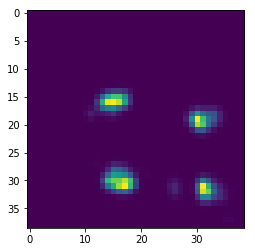

In [38]:
image = mpimg.imread(f'{ob_name}.png')
plt.imshow(image)

### 3D Plots

In [39]:
# %matplotlib widget
%matplotlib inline

In [40]:
def show_3d_grid(name, H, xedges, yedges):
    
    xedges = np.asarray(xedges)
    yedges = np.asarray(yedges)
    
    X, Y = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])
    
    xpos = X.flatten()*1./2
    ypos = Y.flatten()*1./2
    zpos = np.zeros_like(xpos)

    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = H.flatten()

    cmap = mpl.cm.get_cmap('jet') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    
    fig = plt.figure()
    ax = fig.gca(projection='3d', title=name)
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    
    plt.show()

chair


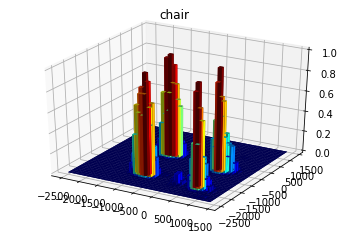

In [42]:
xedges = [i for i in range(x_min, x_max, bin_x)]
yedges = [i for i in range(y_min, y_max, bin_y)]

ob_index = 5  # chair
 
ob_name = list(object_averages.keys())[ob_index]
ob_H = list(object_averages.values())[ob_index]

print(ob_name)

show_3d_grid(ob_name, ob_H, xedges, yedges)